# Multi-Fidelity Bayesian Optimization: Investigating a Minimal Toy Problem

(Inspired by "A Tutorial on Vanilla Bayesian Optimization" by Darian Nwankwo)

In [72]:
using Plots; plot() # warm start plotting engine
using LinearAlgebra
using Distributions
using Optim
using ForwardDiff

In [73]:
include("../src/testfns.jl")
include("../src/surrogates.jl")
include("../src/acquisitions.jl")

plotaf1d (generic function with 1 method)

In [27]:
include("../src/kernels.jl")

## 1. Gather Initial Samples
Our first step is to run some initial experiments and collect our data locations into some matrix $X$ and observations into some vector $y$. Our "experiments" will be random evaluations of some test function; in practice, our function is black-boxed. Put these obervations into an nxd matrix X.

Test Function: GramacyLee


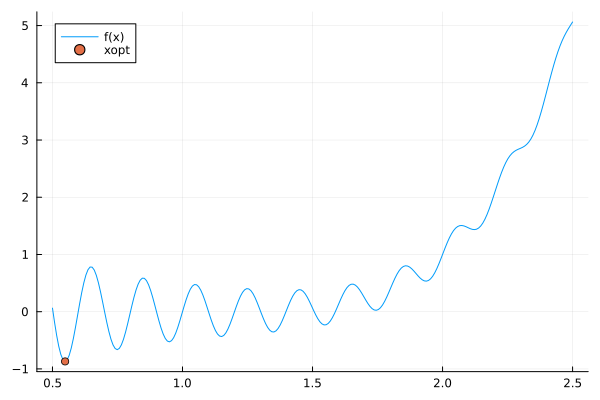

In [28]:
testfn, testfn_name, X, y =  get_toy_problem(N=100, fn_name = "GramacyLee")
println("Test Function: $(testfn_name)")
tplot(testfn)

## 2. Initialize surrogate model

Gather information regarding predictive mean and variance for our function. I will use kernels defined in kernels.jl.

In [31]:
#this will be changed so don't always
ψ = SquaredExponential(1.)

Kernel([1.0], var"#squared_exponential#3019"{Float64}(1.0), var"#squared_exponential_hypers#3020"(), var"#2957#2963"{var"#squared_exponential#3019"{Float64}}(var"#squared_exponential#3019"{Float64}(1.0)), var"#2959#2965"{var"#squared_exponential#3019"{Float64}}(var"#squared_exponential#3019"{Float64}(1.0)), var"#2961#2967"{Vector{Float64}, var"#squared_exponential_hypers#3020"}([1.0], var"#squared_exponential_hypers#3020"()), SquaredExponentialConstructor)

In [41]:
sur = GP(ψ, X, y, noise = 1e-6)

GaussianProcess(Kernel([1.0], var"#squared_exponential#3019"{Float64}(1.0), var"#squared_exponential_hypers#3020"(), var"#2957#2963"{var"#squared_exponential#3019"{Float64}}(var"#squared_exponential#3019"{Float64}(1.0)), var"#2959#2965"{var"#squared_exponential#3019"{Float64}}(var"#squared_exponential#3019"{Float64}(1.0)), var"#2961#2967"{Vector{Float64}, var"#squared_exponential_hypers#3020"}([1.0], var"#squared_exponential_hypers#3020"()), SquaredExponentialConstructor), [2.3629592390089353 0.743687653443144 … 1.8052723208373938 1.494854376615853], [1.000001 0.26954491719049717 … 0.855980786003563 0.6860511947980703; 0.26954491719049717 1.000001 … 0.5692241401376915 0.7541788609427627; … ; 0.855980786003563 0.5692241401376915 … 1.000001 0.9529625719273777; 0.6860511947980703 0.7541788609427627 … 0.9529625719273777 1.000001], [1.000000499999875 0.0 … 0.0 0.0; 0.2695447824181396 0.9629883749408181 … 0.0 0.0; … ; 0.8559803580134909 0.35150902086803154 … 0.0010329812054025373 0.0; 0.6860

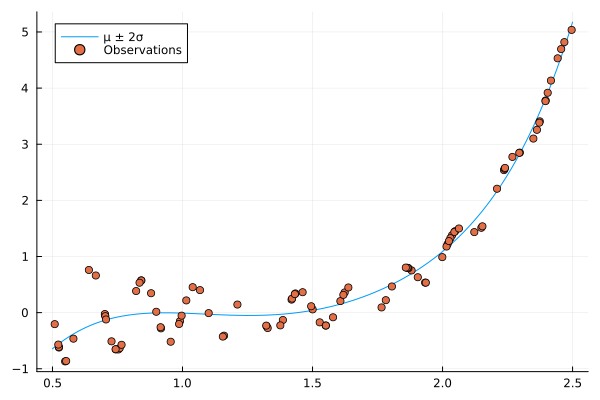

In [46]:
domain = first(testfn.bounds[:, 1]):0.01:first(testfn.bounds[:, 2])
plot1d(sur, interval = domain)

## 3. Construct Acquisition Function

Create some general acquisition functions for this step

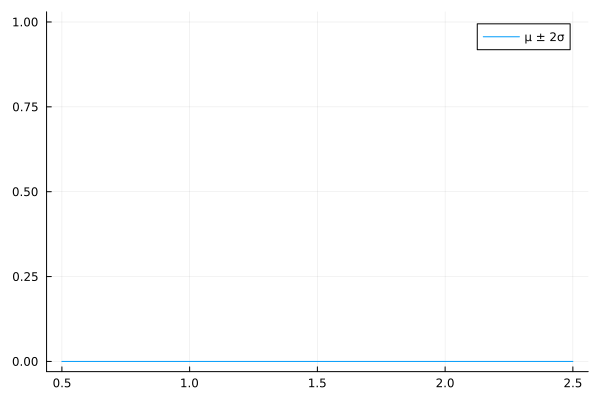

In [48]:
af, af_name = get_random_acquisitionfn(sur)
plotaf1d(af, interval = domain)

## 4. Optimize the acquisition function
Given our acquisition function, optimizing it directly. Thus, select the best location according to the chosen selection criteria.



In [74]:
function optimize_acquisition_functions(sur::GaussianProcess, X::Vector{Float64}, y::Vector{Float64})
    xopt = 1.0
    lb, ub = minimum(X), maximum(X)
    best_val = -Inf
    best_fn = ""

    for (fn_name, fn) in get_acquisition_functions(sur)
        res = optimize(
            x -> -fn.f(x),
            lb,
            ub
        )
        val = -Optim.minimum(res)  # Minimize negative to maximize
        if val > best_val
            best_val = val
            xopt = Optim.minimizer(res)[1]
            best_fn = fn_name
        end
    end

    println("Optimal x: ", xopt)
    println("Optimal value: ", best_val)
    println("Best acquisition function: ", best_fn)
end

optimize_acquisition_functions (generic function with 2 methods)

In [75]:
X_vector = X[1, :]
optimize_acquisition_functions(sur, X_vector, y)

LoadError: type GaussianProcess has no field σ